### Problem 6

#### Create a Robotarium simulation that demonstrates some multi-robot objective of your choosing. Examples could be: formation control with obstacle avoidance (many obstacle avoidance methods exist in the literature, such as potential fields and barrier functions); consensus with time-varying communications graphs such as the wedge graph from Homework 5, consensus on a (simulated) circular as a Kuramoto oscillator system, etc.

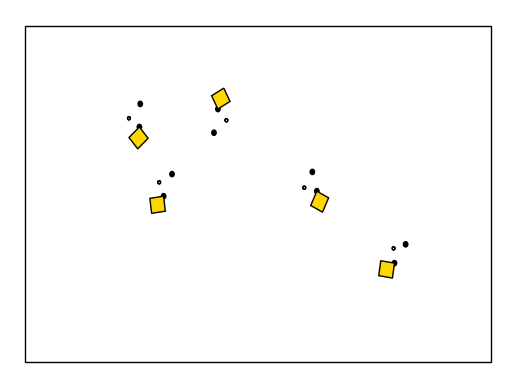

##### DEBUG OUTPUT #####
Your simulation will take approximately 50 real seconds when deployed on the Robotarium. 

	 Simulation had 399 iteration(s) where the actuator limits of at least one robot were exceeded and thresholded to their maximum rotational velocity.


<Figure size 640x480 with 0 Axes>

In [1]:
import rps.robotarium as robotarium
from rps.utilities.graph import *
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np

N = 5

# Initialize list to store trajectories of all agents
trajectories = [[] for _ in range(N)]

# Array representing the geometric distances betwen the agents.  In this case,
# the agents try to form a Rectangle
L = np.array([
    [4, -1, -1, -1, -1],
    [-1, 4, -1, -1, -1],
    [-1, -1, 4, -1, -1],
    [-1, -1, -1, 4, -1],
    [-1, -1, -1, -1, 4],
])
L_2 = np.array([
    [ 0,  0,  0,  0,  0],
    [-1,  2, -1,  0,  0],
    [-1, -1,  2,  0,  0],
    [-1, -1, -1,  4, -1],
    [-1, -1, -1, -1,  4],
])

# Some gains for this experiment.  These aren't incredibly relevant.
d = 0.6
ddiag_1 = np.sqrt(2)*d
ddiag_2 = np.sqrt(5)*d
formation_control_gain = 10

# Weight matrix to control inter-agent distances
weights = np.array([
    [0,         d,       d,       d,     2*d],
    [d,         0,     2*d, ddiag_1, ddiag_2],
    [d,       2*d,       0, ddiag_1, ddiag_2],
    [d,   ddiag_1, ddiag_1,       0,       d],
    [2*d, ddiag_2, ddiag_2,       d,       0],
])
# Weight matrix to control inter-agent distances
weights_2 = weights / 2

# Experiment constants
iterations = 1500
N = 5

#Limit maximum linear speed of any robot
magnitude_limit = 0.15

r = robotarium.Robotarium(number_of_robots=N, show_figure=True, sim_in_real_time=False)
# We're working in single-integrator dynamics, and we don't want the robots
# to collide or drive off the testbed.  Thus, we're going to use barrier certificates
si_barrier_cert = create_single_integrator_barrier_certificate_with_boundary()

# Create SI to UNI dynamics tranformation
si_to_uni_dyn, uni_to_si_states = create_si_to_uni_mapping()

for k in range(iterations):

    # Get the poses of the robots
    x = r.get_poses()
    
    # Record the current positions of all agents
    for i in range(N):
        trajectories[i].append(x[:2, i].copy())

    if k < 500:
    
        # Initialize a velocity vector
        dxi = np.zeros((2, N))
        _formation_control_gain = formation_control_gain * max(1, (k % 1000) / 100)
    
        for i in range(N):
            _L = L
            for j in topological_neighbors(_L, i):
                # Perform a weighted consensus to make the rectangular shape
                error = x[:2, j] - x[:2, i]
                dxi[:, i] += formation_control_gain*(np.power(np.linalg.norm(error), 2)- np.power(weights[i, j], 2)) * error
    
        #Keep single integrator control vectors under specified magnitude
        # Threshold control inputs
        norms = np.linalg.norm(dxi, 2, 0)
        idxs_to_normalize = (norms > magnitude_limit)
        dxi[:, idxs_to_normalize] *= magnitude_limit/norms[idxs_to_normalize]
    
        # Make sure that the robots don't collide
        dxi = si_barrier_cert(dxi, x[:2, :])
    
        # Transform the single-integrator dynamcis to unicycle dynamics
        dxu = si_to_uni_dyn(dxi, x)
        #print(k)
        #print(dxu)
    
        # Set the velocities of the robots
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()

    elif k >= 500 and k < 1000: 
        # Initialize a velocity vector
        dxi = np.zeros((2, N))
    
        for i in range(N):
            for j in topological_neighbors(L_2, i):
                # Perform a weighted consensus to make the rectangular shape
                error = x[:2, j] - x[:2, i]
                dxi[:, i] += formation_control_gain*(np.power(np.linalg.norm(error), 2)- np.power(weights_2[i, j], 2)) * error
    
        #Keep single integrator control vectors under specified magnitude
        # Threshold control inputs
        norms = np.linalg.norm(dxi, 2, 0)
        idxs_to_normalize = (norms > magnitude_limit)
        dxi[:, idxs_to_normalize] *= magnitude_limit/norms[idxs_to_normalize]
    
        # Make sure that the robots don't collide
        dxi = si_barrier_cert(dxi, x[:2, :])
    
        # Transform the single-integrator dynamcis to unicycle dynamics
        dxu = si_to_uni_dyn(dxi, x)
    
        # Set the velocities of the robots
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()

    else:
        # Initialize a velocity vector
        dxi = np.zeros((2, N))

        # Compute the rotation matrix
        cos_theta = np.cos(np.pi/2)
        sin_theta = np.sin(np.pi/2)
        rotation_matrix = np.array([
            [cos_theta, -sin_theta],
            [sin_theta, cos_theta]
        ])
        
        dxi[:, 0] += np.dot(rotation_matrix, x[:2, 1] - x[:2, 0]) / 2

        #Keep single integrator control vectors under specified magnitude
        # Threshold control inputs
        norms = np.linalg.norm(dxi, 2, 0)
        idxs_to_normalize = (norms > magnitude_limit)
        dxi[:, idxs_to_normalize] *= magnitude_limit/norms[idxs_to_normalize]
    
        # Make sure that the robots don't collide
        dxi = si_barrier_cert(dxi, x[:2, :])
    
        # Transform the single-integrator dynamcis to unicycle dynamics
        dxu = si_to_uni_dyn(dxi, x)
    
        # Set the velocities of the robots
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
        
    
#Call at end of script to print debug information and for your script to run on the Robotarium server properly
r.call_at_scripts_end()

In [2]:
# =========================== #
#       Plot Trajectories     #
# =========================== #

# Convert trajectories to numpy arrays for plotting
trajectories = [np.array(traj).T for traj in trajectories]

### My implementation: Draw a "GT" with rescaled formation control under leader-follower network.

#### Initial condition
* 5 agents with random initial condition.

#### Stage 1: Form a "T" with formation control
* Use a complete graph with the following weights to position 5 agents in a shape of "T":
```
# Laplacian for K_5
L = np.array([
    [4, -1, -1, -1, -1],
    [-1, 4, -1, -1, -1],
    [-1, -1, 4, -1, -1],
    [-1, -1, -1, 4, -1],
    [-1, -1, -1, -1, 4],
])

d = 0.6
ddiag_1 = np.sqrt(2)*d
ddiag_2 = np.sqrt(5)*d

# Weight matrix to control inter-agent distances
weights = np.array([
    [0,         d,       d,       d,     2*d],
    [d,         0,     2*d, ddiag_1, ddiag_2],
    [d,       2*d,       0, ddiag_1, ddiag_2],
    [d,   ddiag_1, ddiag_1,       0,       d],
    [2*d, ddiag_2, ddiag_2,       d,       0],
])
```

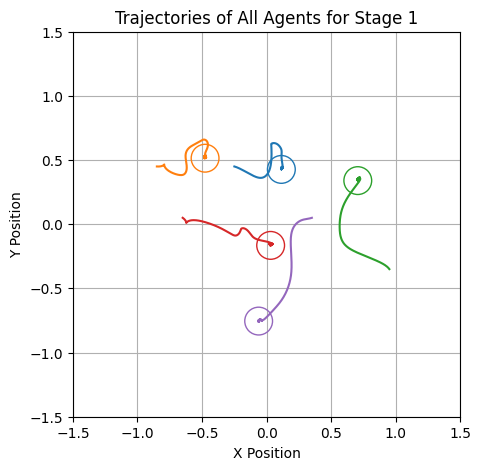

In [3]:
plt.figure(figsize=(5, 5))
for i in range(N):
    plt.plot(
        trajectories[i][0][:500], trajectories[i][1][:500], label=f'Agent {i + 1}', color=f"C{i}"
    )
    plt.scatter(
        trajectories[i][0][500], trajectories[i][1][500], 
        label=f'Start Agent {i + 1}', facecolor='none', s=400, zorder=5, color=f"C{i}"
    )

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectories of All Agents for Stage 1')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
#plt.legend()
#plt.axis('equal')
plt.grid(True)
plt.show()

#### Stage 2: Draw a "T" with lead-follower rescaled formation control
* Now, choose the agent at the intersection of "T" as the static leader.
```
# Laplacian for a leader-follower graph (the leader is selected as the first agent in this matrix)
L_2 = np.array([
    [ 0,  0,  0,  0,  0],
    [-1,  2, -1,  0,  0],
    [-1, -1,  2,  0,  0],
    [-1, -1, -1,  4, -1],
    [-1, -1, -1, -1,  4],
])
```
* Rescale the weight matrix so that all the remaining agents converge to the static leader.


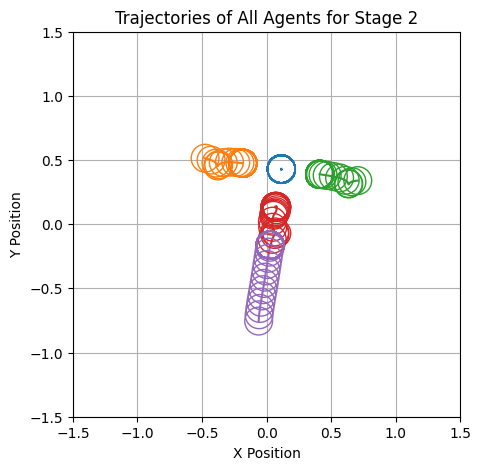

In [4]:
plt.figure(figsize=(5, 5))
for i in range(N):
    plt.plot(
        trajectories[i][0][500:1000], trajectories[i][1][500:1000], label=f'Agent {i + 1}', color=f"C{i}"
    )
    for j in range(500, 1000, 10):
        plt.scatter(
            trajectories[i][0][j], trajectories[i][1][j], 
            label=f'Start Agent {i + 1}', facecolor='none', s=400, zorder=5, color=f"C{i}"
        )

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectories of All Agents for Stage 2')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
#plt.legend()
#plt.axis('equal')
plt.grid(True)
plt.show()


#### Stage 3: Draw a "G" with lead-follower control
* Now, choose the agent at the left wing of "T" as the static leader and the leader in stage 2 as the only follower.

* Control the only follower to circulate around the leader (the left wing og "T") to draw the "G" for GT.

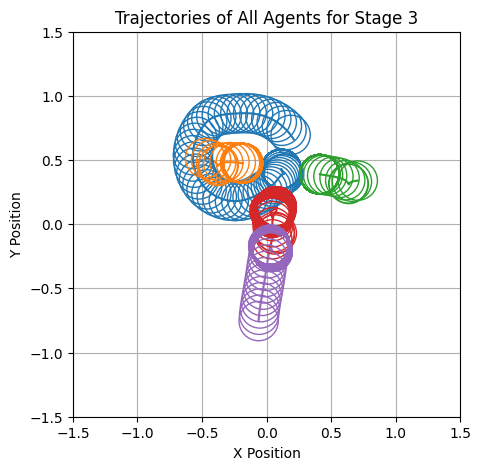

In [5]:
plt.figure(figsize=(5, 5))
for i in range(N):
    plt.plot(
        trajectories[i][0][500:1500], trajectories[i][1][500:1500], label=f'Agent {i + 1}', color=f"C{i}"
    )
    for j in range(500, 1500, 10):
        plt.scatter(
            trajectories[i][0][j], trajectories[i][1][j], 
            label=f'Start Agent {i + 1}', facecolor='none', s=800, zorder=5, color=f"C{i}"
        )

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectories of All Agents for Stage 3')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
#plt.legend()
#plt.axis('equal')
plt.grid(True)
plt.show()
